In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import CelebA

### 아래 주소에서 dataset을 다운로드 한 뒤 /data/celeba에 압축을 풉니다.
### https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing

### Celeba Pytorch Dataset

In [2]:
root = '/data'

train_transforms = transforms.Compose([transforms.CenterCrop(148),
                                       transforms.Resize(512),
                                       transforms.ToTensor(),
                                       transforms.Normalize(0.5, 0.5)])

dataset = CelebA(root, split='train', transform=train_transforms, download=False)
dataset

Dataset CelebA
    Number of datapoints: 162770
    Root location: /data
    Target type: ['attr']
    Split: train
    StandardTransform
Transform: Compose(
               CenterCrop(size=(148, 148))
               Resize(size=512, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [6]:
len(dataset)

162770

In [7]:
x, y = dataset[6]
x = ((x + 1) * 127.5).clamp(0, 255).to(torch.uint8)
x = x.permute(1, 2, 0)
x = x.contiguous()
x = x.data.cpu().numpy()
x.shape

(512, 512, 3)

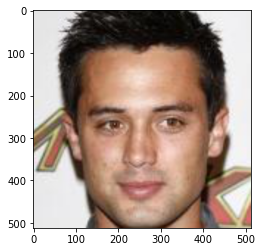

In [8]:
import matplotlib.pyplot as plt

plt.imshow(x)
plt.show()

### Dataset에 있는 attributes를 이용해서 트레이닝에 사용할 text를 만들어 줍니다.

In [9]:
attributes = [
    "5_o_Clock_Shadow", "Arched_Eyebrows", "Attractive", "Bags_Under_Eyes", 
    "Bald", "Bangs", "Big_Lips", "Big_Nose", "Black_Hair", "Blond_Hair", 
    "Blurry", "Brown_Hair", "Bushy_Eyebrows", "Chubby", "Double_Chin", 
    "Eyeglasses", "Goatee", "Gray_Hair", "Heavy_Makeup", "High_Cheekbones", 
    "Male", "Mouth_Slightly_Open", "Mustache", "Narrow_Eyes", "No_Beard", 
    "Oval_Face", "Pale_Skin", "Pointy_Nose", "Receding_Hairline", "Rosy_Cheeks", 
    "Sideburns", "Smiling", "Straight_Hair", "Wavy_Hair", "Wearing_Earrings", 
    "Wearing_Hat", "Wearing_Lipstick", "Wearing_Necklace", "Wearing_Necktie", 
    "Young"
]

In [10]:
def get_text(y, attributes):
    text = ""
    for i in range(len(attributes)):
        if y[i] == 1:
            text += attributes[i].lower()
            if i < len(attributes)-1:
                text += ', '
    return text

In [11]:
get_text(y, attributes)

'5_o_clock_shadow, attractive, bags_under_eyes, big_lips, big_nose, black_hair, bushy_eyebrows, male, no_beard, pointy_nose, straight_hair, young'

### Image/text pair data를 저장합니다.

In [12]:
!mkdir /data/sd_dataset
!mkdir /data/sd_dataset/celeba

mkdir: cannot create directory ‘/data/sd_dataset’: File exists


In [ ]:
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
import torch
import numpy as np
from tqdm import tqdm

# Assume get_text and dataset are defined elsewhere

def process_item(i):
    x, y = dataset[i]
    x = ((x + 1) * 127.5).clamp(0, 255).to(torch.uint8)
    x = x.permute(1, 2, 0)
    x = x.contiguous()
    x = x.data.cpu().numpy()
    
    text = get_text(y, attributes)
    
    img = Image.fromarray(x)
    img.save('/data/sd_dataset/celeba/' + str(i) + '.jpg')
    
    with open('/data/sd_dataset/celeba/' + str(i) + '.txt', 'w') as f:
        f.write('celeba, ' + text)

# Number of threads
num_threads = 64

# Create a ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    # Submit tasks to the executor
    list(tqdm(executor.map(process_item, range(10000)), total=10000))


 99%|██████████████████████████████████████████████████████████████▎| 9890/10000 [00:51<00:00, 187.68it/s]